In [1]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

In [2]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [4]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [5]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = first_degree - results
            results.add(np.random.choice(list(unique)))
        elif len(second_degree) - len(results) > 0:
            unique = second_degree - results
            results.add(np.random.choice(list(unique)))
        else:
            unique = all_nodes - results
            results.add(np.random.choice(list(unique)))
    return results

In [6]:
#sample_neighbors(g, "RPL5", 5, include_self=False)

In [7]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
    
    
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        
        patience = 20
        opt.num_layer = self.num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
        
        if self.model == "CGN":
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
            
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            if self.cuda:
                model.cuda()
                model.on_cuda = True
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()
            time_this_epoch = time.time() - start_timer
            
            
            auc = {}
            if self.cuda:
                model.cpu()
                model.on_cuda = False

            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            #print auc['test']
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            print summary

            patience = patience - 1
            if patience == 0:
                return auc['test']
                break
            if max_valid < auc['valid']:
                max_valid = auc['valid']
            if max_valid > auc['valid'] and t > 15:
                #scores.append(auc['test']) 
                #print "returning", auc['test']
                return auc['test']
                break

In [8]:
def method_comparison(results, dataset, models, gene, max_genes, trials, train_size, test_size):
    
    dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    print "Max ex ", int(np.log2(max_genes))+1
    for ex in range(4, int(np.log2(max_genes))+1):
        
        num_genes = 2**ex
        num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
        print ex, num_genes
        
        neighbors = sample_neighbors(g, gene, num_genes, include_self=False)
        print "neighbors", len(neighbors)
        
        if gene in neighbors:
            neighbors.remove(gene)

        dataset.df = dataset.df[list(neighbors)]
        dataset.data = dataset.df.as_matrix()
        
        neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
        
        for model in models:
            for seed in range(trials):
            
                #have we already done it?
                already_done = results["df"][(results["df"].gene_name == gene) & 
                                             (results["df"].model == model['key']) &
                                             (results["df"].num_genes == num_genes) &
                                             (results["df"].seed == seed) &
                                             (results["df"].train_size == train_size)].shape[0] > 0

                if already_done:
                    print "already done:", model['key'], num_genes, seed
                    continue
                print "doing:", model['key'], num_genes, seed

                result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                experiment = {"gene_name": gene,
                        "model": model['key'],
                        "num_genes": num_genes, 
                        "seed":seed,
                        "train_size": train_size,
                        "auc":result
                        }

                results["df"] = results["df"].append(experiment, ignore_index=True)
                pickle.dump(results, open("results-temp.pkl", "wb"))
        dataset.df = full_df
    

In [16]:
import data
reload(data)
#reload(models.models)
reload(gene_inference)
#reload(gene_inference.models)
reload(analysis.metrics)
import pickle

m = [
    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
    {'key': 'DT', 'method': SkLearn("DT")},
#   {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
#   {'key': 'MLP-dropout', 'method': PyTorch("MLP")},
    ]



In [10]:
#results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [10]:
#results = pickle.load(open("results-temp.pkl", "r"))

In [17]:
method_comparison(results, tcgatissue, m, gene="RPL5", max_genes=9000, trials=2, train_size=100, test_size=1000)

Converting one-hot labels to integers
Max ex  14
4 16
neighbors 16
already done: LR-L1 16 0
already done: LR-L1 16 1
already done: DT 16 0
already done: DT 16 1
5 32
neighbors 32
already done: LR-L1 32 0
already done: LR-L1 32 1
already done: DT 32 0
already done: DT 32 1
6 64
neighbors 64
already done: LR-L1 64 0
already done: LR-L1 64 1
already done: DT 64 0
already done: DT 64 1
7 128
neighbors 128
already done: LR-L1 128 0
already done: LR-L1 128 1
already done: DT 128 0
already done: DT 128 1
8 256
neighbors 256
already done: LR-L1 256 0
already done: LR-L1 256 1
already done: DT 256 0
already done: DT 256 1
9 512
neighbors 512
already done: LR-L1 512 0
already done: LR-L1 512 1
already done: DT 512 0
already done: DT 512 1
10 1024
neighbors 1024
already done: LR-L1 1024 0
already done: LR-L1 1024 1
already done: DT 1024 0
already done: DT 1024 1
11 2048
neighbors 2048
doing: LR-L1 2048 0
doing: LR-L1 2048 1
doing: DT 2048 0
doing: DT 2048 1
12 4096
neighbors 4096
doing: LR-L1 409

In [20]:
import pickle
#pickle.dump(results, open("results.pkl", "wb"))

In [31]:
#results = pickle.load(open("results.pkl", "r"))

In [51]:
results["df"]

,auc,gene_name,model,num_genes,seed,train_size
0,0.800461,RPL5,LR-L1,16,0,100
1,0.822363,RPL5,LR-L1,16,1,100
2,0.832213,RPL5,LR-L1,16,2,100
3,0.731107,RPL5,DT,16,0,100
4,0.760795,RPL5,DT,16,1,100
5,0.801509,RPL5,DT,16,2,100
6,0.773086,RPL5,LR-L1,32,0,100
7,0.812424,RPL5,LR-L1,32,1,100
8,0.816969,RPL5,LR-L1,32,2,100
9,0.735812,RPL5,DT,32,0,100


In [18]:
grouped = results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].agg(['mean','std', 'count'])
grouped

mean       std  \
gene_name model                                 num_genes                       
RPL5      CGN_3_layer_64_channel_emb_32_dropout 16         0.884154  0.008160   
                                                32         0.889814  0.030178   
                                                64         0.910562  0.032372   
                                                128        0.915712  0.013903   
                                                256        0.924305  0.013063   
                                                512        0.914658  0.008584   
                                                1024       0.898535  0.011743   
                                                2048       0.845128  0.036117   
          DT                                    16         0.760771  0.025832   
                                                32         0.773893  0.023490   
                                                64         0.778796  0.033080   
                                                128        0.775419  0.026961   
                                                256        0.782436  0.034340   
                                                512        0.796946  0.013723   
                                                1024       0.771543  0.019358   
                                                2048       0.756102  0.033458   
                                                4096       0.754941  0.044570   
                                                8192       0.753009  0.054897   
          LR-L1                                 16         0.815425  0.014253   
                                                32         0.813424  0.025651   
                                                64         0.837464  0.012902   
                                                128        0.822951  0.015170   
                                                256        0.833170  0.013815   
                                                512        0.812256  0.027872   
                                                1024       0.793053  0.035320   
                                                2048       0.754381  0.061704   
                                                4096       0.735836  0.043739   
                                                8192       0.721357  0.004849   
          MLP-dropout                           16         0.908190  0.007624   
                                                32         0.880014  0.018108   
                                                64         0.902317  0.014856   
                                                128        0.913143  0.008110   
                                                256        0.925052  0.009755   
                                                512        0.913289  0.010302   
                                                1024       0.892497  0.010847   
                                                2048       0.852810  0.016475   
                                                4096       0.818636  0.031218   
                                                8192       0.792722  0.030958   

                                                           count  
gene_name model                                 num_genes         
RPL5      CGN_3_layer_64_channel_emb_32_dropout 16             5  
                                                32             3  
                                                64             4  
                                                128            3  
                                                256            5  
                                                512            4  
                                                1024           4  
                                                2048           2  
          DT                                    16             5  
                                                32             5  
                  

In [12]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

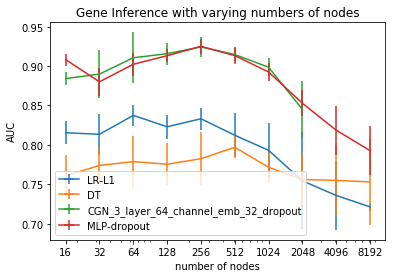

In [19]:
%matplotlib inline
for model in results["df"]["model"].unique():
    index = results["df"].groupby(['model','num_genes'])['auc'].mean()[model].index
    mean = results["df"].groupby(['model','num_genes'])['auc'].mean()[model]
    stderr = results["df"].groupby(['model','num_genes'])['auc'].std()[model]
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)


plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [ ]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)